In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmedcurious","key":"98085c532fcfe932ca94f004b5197007"}'}

In [3]:
! chmod 600 /content/kaggle/kaggle.json

In [4]:
!kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 93% 321M/346M [00:01<00:00, 141MB/s]
100% 346M/346M [00:02<00:00, 174MB/s]


In [5]:
!unzip intel-image-classification.zip -d intel_image_classification

Streaming output truncated to the last 5000 lines.
  inflating: intel_image_classification/seg_train/seg_train/mountain/7506.jpg  
  inflating: intel_image_classification/seg_train/seg_train/mountain/7537.jpg  
  inflating: intel_image_classification/seg_train/seg_train/mountain/7539.jpg  
  inflating: intel_image_classification/seg_train/seg_train/mountain/7551.jpg  
  inflating: intel_image_classification/seg_train/seg_train/mountain/7560.jpg  
  inflating: intel_image_classification/seg_train/seg_train/mountain/7565.jpg  
  inflating: intel_image_classification/seg_train/seg_train/mountain/7578.jpg  
  inflating: intel_image_classification/seg_train/seg_train/mountain/7581.jpg  
  inflating: intel_image_classification/seg_train/seg_train/mountain/7586.jpg  
  inflating: intel_image_classification/seg_train/seg_train/mountain/7647.jpg  
  inflating: intel_image_classification/seg_train/seg_train/mountain/7652.jpg  
  inflating: intel_image_classification/seg_train/seg_train/mountain/

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt
import numpy as np
import os


Categories: ['mountain', 'glacier', 'sea', 'street', 'buildings', 'forest']


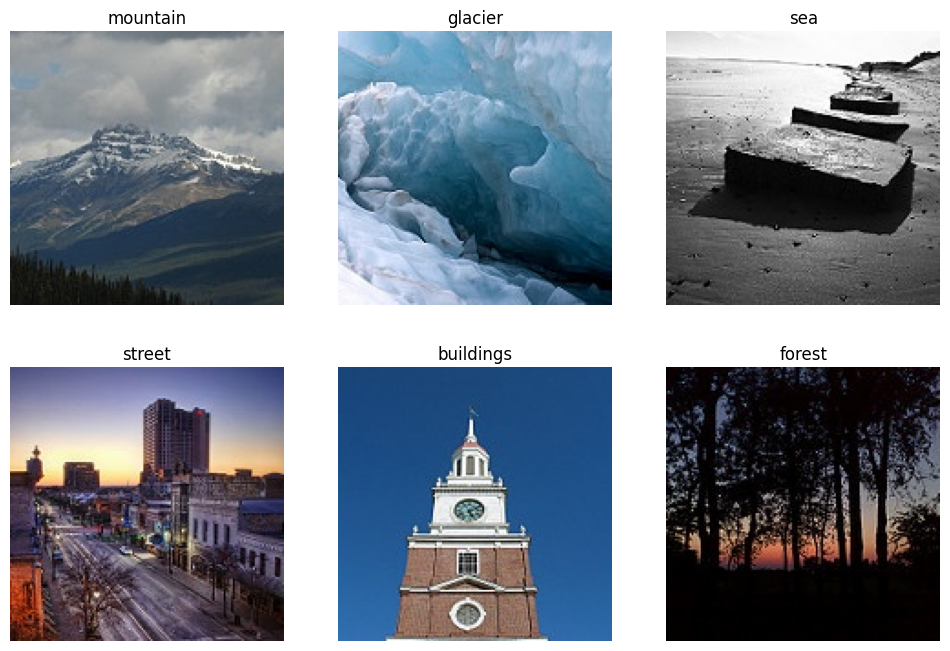

In [8]:
train_dir = '/content/intel_image_classification/seg_test/seg_test'
test_dir = '/content/intel_image_classification/seg_train/seg_train'

categories = os.listdir(train_dir)
print("Categories:", categories)

plt.figure(figsize=(12, 8))
for i, category in enumerate(categories[:6]):
    img_path = os.path.join(train_dir, category, os.listdir(os.path.join(train_dir, category))[0])
    img = plt.imread(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(category)
    plt.axis("off")
plt.show()


In [9]:
# Create ImageDataGenerator objects for training and testing
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


Found 3000 images belonging to 6 classes.
Found 14034 images belonging to 6 classes.


In [10]:
# Load the pre-trained ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model
base_model.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(len(categories), activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 156, 156, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 75, 75, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 75, 75, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 75, 75, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 77, 77, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 38, 38, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 38, 38, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 38, 38, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 38, 38, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 38, 38, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 26,213,766 (100.00 MB)

 Trainable params: 2,626,054 (10.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [11]:
# Train the model on the training data and validate on the test set
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,  # you can adjust the number of epochs
    verbose=1
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 80s 712ms/step - accuracy: 0.1863 - loss: 1.9346 - val_accuracy: 0.3772 - val_loss: 1.5949
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 40s 420ms/step - accuracy: 0.3256 - loss: 1.5678 - val_accuracy: 0.3456 - val_loss: 1.4272
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 421ms/step - accuracy: 0.3484 - loss: 1.4673 - val_accuracy: 0.4342 - val_loss: 1.3004
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 425ms/step - accuracy: 0.3818 - loss: 1.3921 - val_accuracy: 0.4571 - val_loss: 1.2581
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 426ms/step - accuracy: 0.4191 - loss: 1.3177 - val_accuracy: 0.4691 - val_loss: 1.2446
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 81s 423ms/step - accuracy: 0.4396 - loss: 1.3107 - val_accuracy: 0.4897 - val_loss: 1.1745
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 430ms/step - accuracy: 0.4618 - loss: 1.2374 - val_accuracy: 0.4801 - val_loss: 1.1727
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 81s 419ms/step - accuracy: 0.4407 - loss: 1.2638 - val_accuracy: 0.494

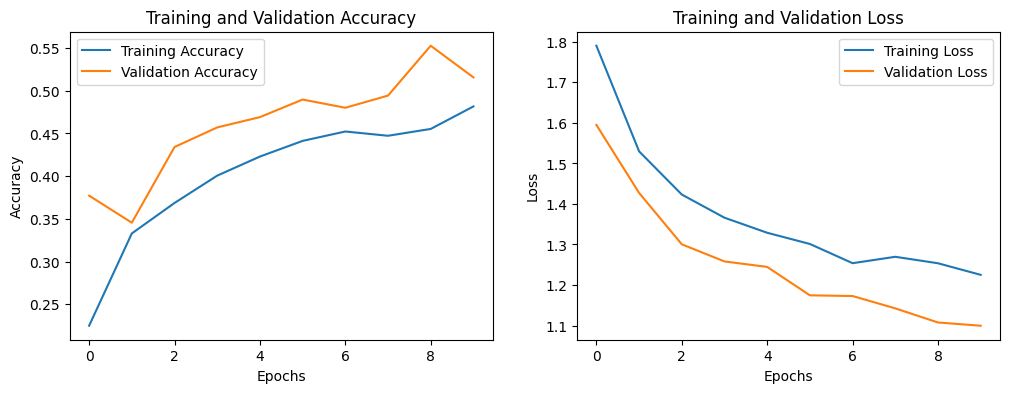

In [12]:
# Plot the accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [16]:
import os
from tensorflow.keras.preprocessing import image

# Define the path to the prediction images
pred_dir = '/content/intel_image_classification/seg_pred/seg_pred'

# Load and preprocess the images
pred_images = []
pred_filenames = []

for img_file in os.listdir(pred_dir):
    img_path = os.path.join(pred_dir, img_file)
    img = image.load_img(img_path, target_size=(150, 150))  # Load the image
    img_array = image.img_to_array(img) / 255.0  # Convert to array and normalize
    pred_images.append(img_array)
    pred_filenames.append(img_file)

# Convert list to numpy array
pred_images = np.array(pred_images)


In [17]:
# Generate predictions
predictions = model.predict(pred_images)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
class_labels = list(train_generator.class_indices.keys())
predicted_labels = [class_labels[i] for i in predicted_classes]


229/229 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step


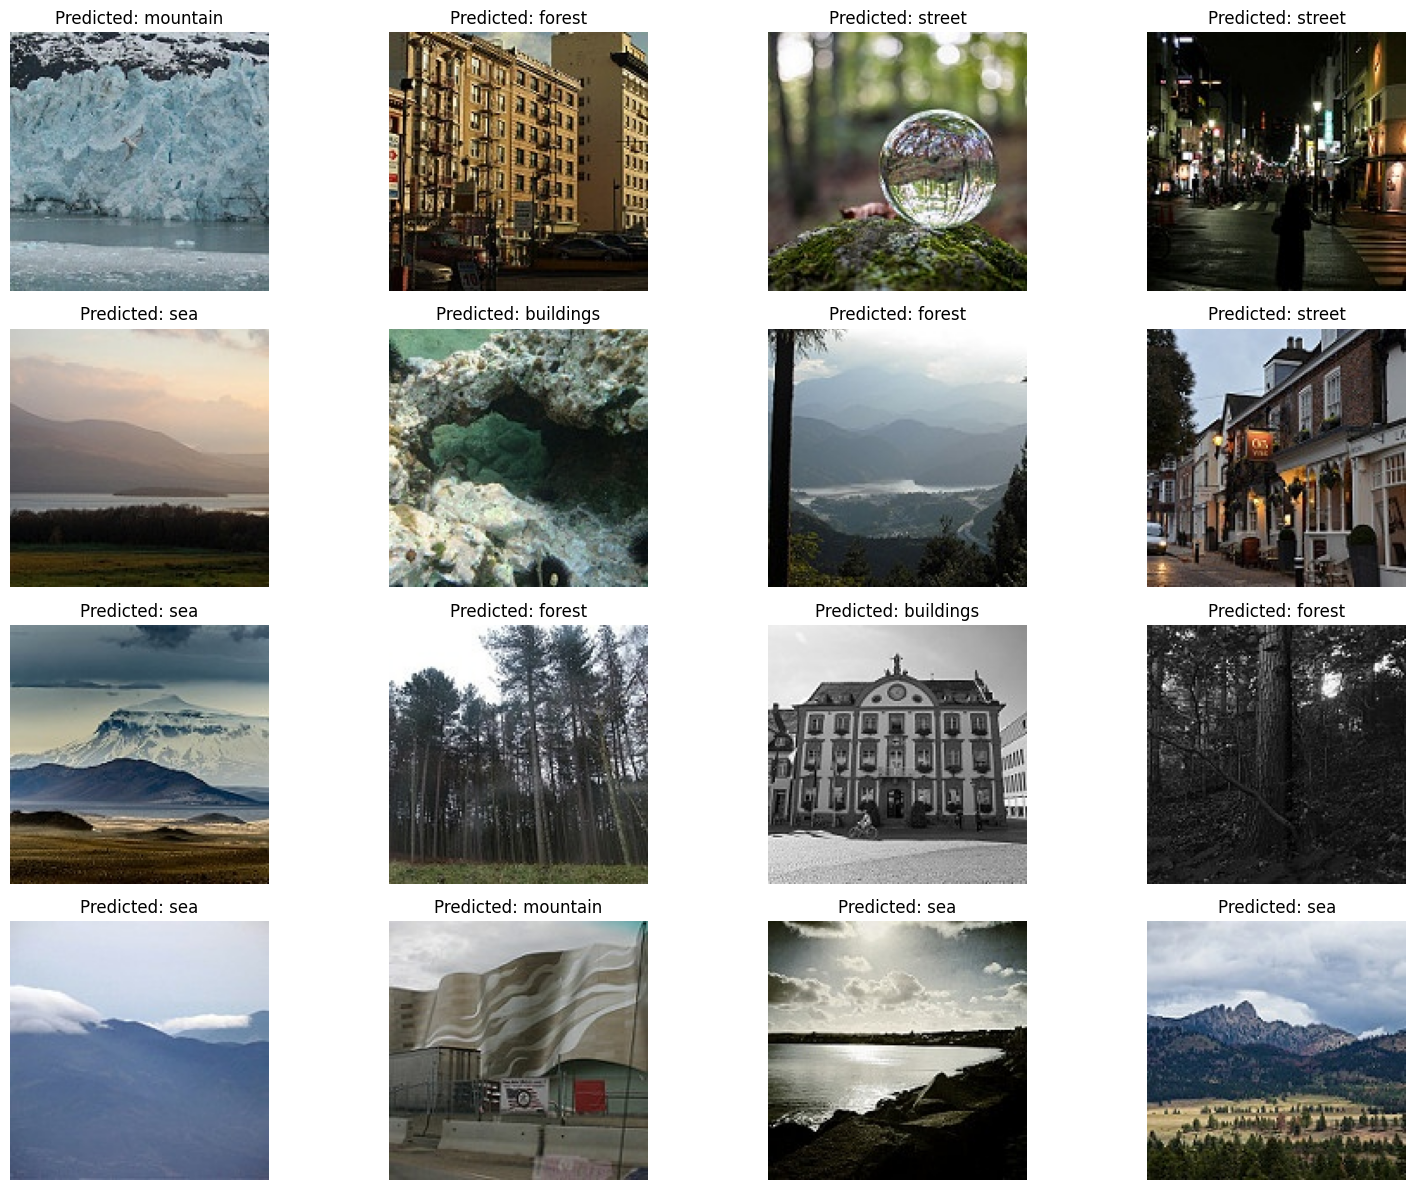

In [19]:
# Plot a few prediction images with their predicted labels
plt.figure(figsize=(16, 12))  # Increase the figure size for better visibility
num_images_to_display = min(16, len(pred_images))  # Set the number of images to display

for i in range(num_images_to_display):
    plt.subplot(4, 4, i + 1)  # Adjust subplot for 4 rows and 4 columns
    plt.imshow(pred_images[i])
    plt.title(f'Predicted: {predicted_labels[i]}')
    plt.axis('off')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Create the ImageDataGenerator for training with augmentations
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create the ImageDataGenerator for validation (no augmentation)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

# Compile and train the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    callbacks=[lr_scheduler]
)


Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 70s 578ms/step - accuracy: 0.3277 - loss: 2.2144 - val_accuracy: 0.2024 - val_loss: 3.7436 - learning_rate: 0.0010
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 65s 449ms/step - accuracy: 0.4321 - loss: 1.2554 - val_accuracy: 0.5197 - val_loss: 1.2149 - learning_rate: 0.0010
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 82s 460ms/step - accuracy: 0.4853 - loss: 1.1875 - val_accuracy: 0.4362 - val_loss: 1.2784 - learning_rate: 0.0010
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 64s 673ms/step - accuracy: 0.5121 - loss: 1.1412 - val_accuracy: 0.5381 - val_loss: 1.1378 - learning_rate: 0.0010
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 62s 454ms/step - accuracy: 0.5365 - loss: 1.1302 - val_accuracy: 0.3181 - val_loss: 2.0838 - learning_rate: 0.0010
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 83s 462ms/step - accuracy: 0.5414 - loss: 1.0950 - val_accuracy: 0.5644 - val_loss: 1.0394 - learning_rate: 0.0010
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 45s 462ms/step - accuracy: 0.5613 - loss: 1.

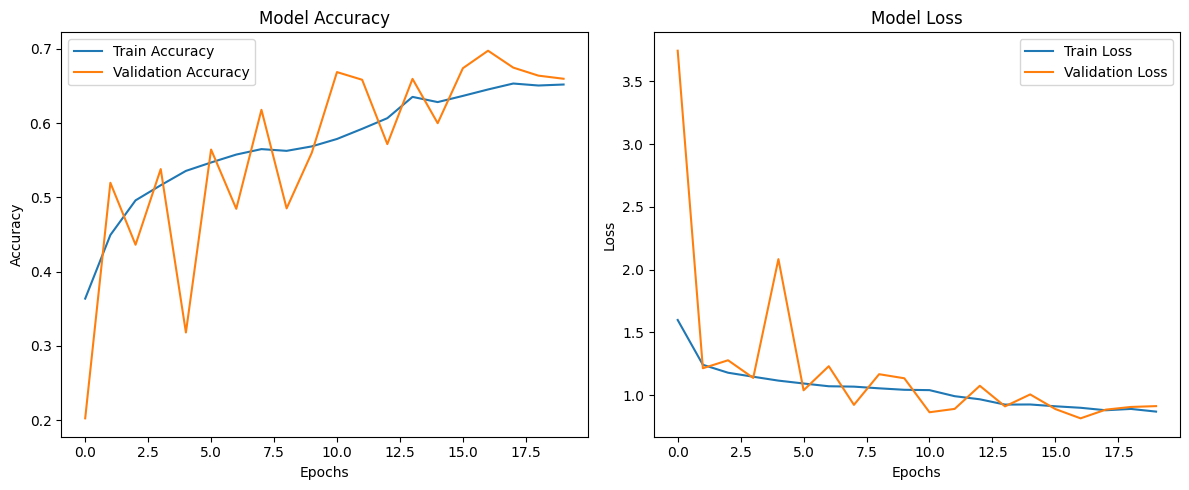

In [22]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


229/229 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step


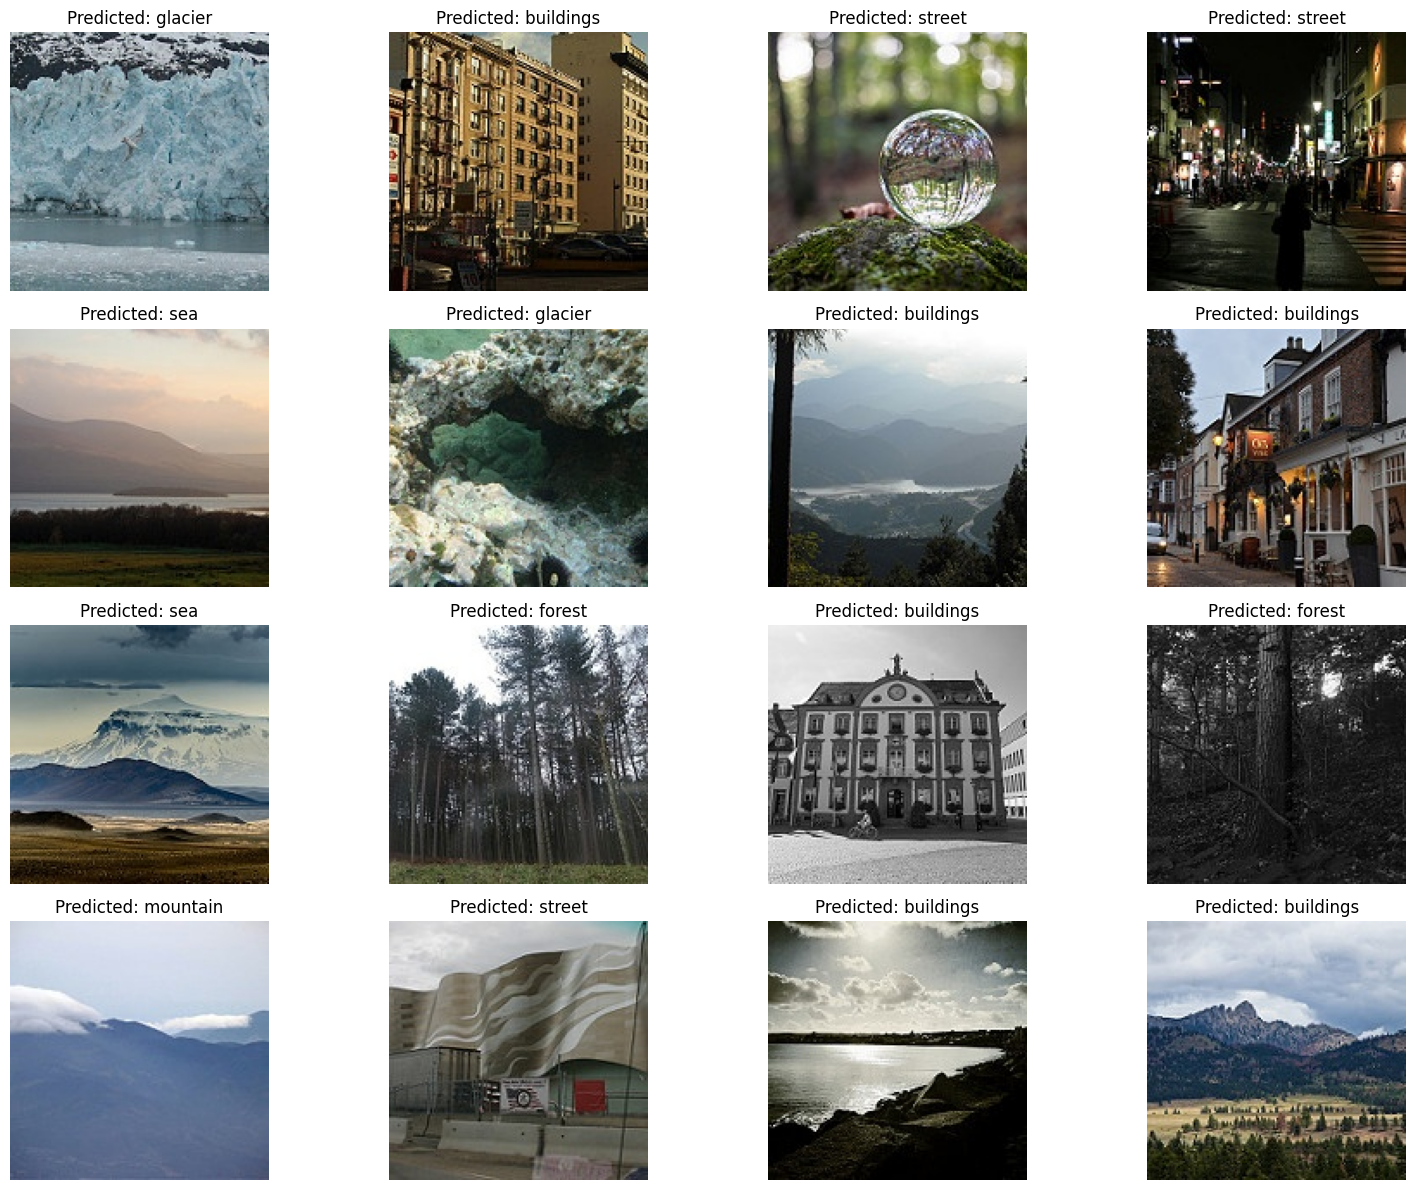

In [23]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load prediction images
pred_path = '/content/intel_image_classification/seg_pred/seg_pred'
pred_images = []
pred_labels = []

# Load images from the prediction directory
for img_name in os.listdir(pred_path):
    img_path = os.path.join(pred_path, img_name)
    img = image.load_img(img_path, target_size=(150, 150))  # Change to your input size
    img_array = image.img_to_array(img) / 255.0  # Normalize the image
    pred_images.append(img_array)
    pred_labels.append(img_name)  # Store the filename for reference

pred_images = np.array(pred_images)

# Make predictions
predictions = model.predict(pred_images)
predicted_classes = np.argmax(predictions, axis=1)

# Get class indices to convert to labels
class_indices = train_generator.class_indices
labels = {v: k for k, v in class_indices.items()}  # Reverse the mapping

# Map predicted classes to their corresponding labels
predicted_labels = [labels[class_idx] for class_idx in predicted_classes]

# Display prediction images and their labels
plt.figure(figsize=(16, 12))
num_images_to_display = min(16, len(pred_images))  # Set the number of images to display

for i in range(num_images_to_display):
    plt.subplot(4, 4, i + 1)  # Adjust subplot for 4 rows and 4 columns
    plt.imshow(pred_images[i])
    plt.title(f'Predicted: {predicted_labels[i]}')
    plt.axis('off')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()
